<a href="https://colab.research.google.com/github/Het-Shah/Meme-Classification/blob/master/nnfl_proj_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Mon Nov 25 18:47:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Found GPU at: /device:GPU:0


NameError: ignored

In [0]:
# !pip install pytorch-transformers
pip install langdetect

In [0]:
!pip install pillow
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, Bidirectional, LSTM, Flatten, concatenate, Dropout, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU, GRU
from keras import optimizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet import ResNet50

import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
# from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
# from pytorch_transformers import AdamW

from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

import copy
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Pickle imports

In [0]:
import pickle 
with open('/content/drive/My Drive/nnfl_pkls/img.pkl', 'rb') as f:
  X_img = pickle.load(f)

with open('/content/drive/My Drive/nnfl_pkls/taskA.pkl','rb') as f:
  y1 = pickle.load(f)

with open('/content/drive/My Drive/nnfl_pkls/taskB.pkl','rb') as f:
  y2 = pickle.load(f)

with open('/content/drive/My Drive/nnfl_pkls/taskC.pkl','rb') as f:
  y3 = pickle.load(f)

with open('/content/drive/My Drive/nnfl_pkls/dataframe.pkl','rb') as f:
  df = pickle.load(f)

In [0]:
with open('/content/drive/My Drive/nnfl_pkls/text.pkl','rb') as f:
  X_text = pickle.load(f)

# Pre processing and pytorch

In [0]:
text = "10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious 10 Year Challenge Memes | What is #10 Year Challenge? "
text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
text = re.sub(r'^\w+'," ", text)
text = re.sub(r'\d+', " ", text)
print(text)

  YEAR CHALLENGE WITH NO FILTER   Hilarious   Year Challenge Memes  What is   Year Challenge 


In [0]:
df = pd.read_csv("/content/drive/My Drive/data_7000_new.csv",header=None,names=["imgname","imgpath","imgtext1","imgtext2","funniness","sarcasm","offense","motivation","sentiment"])
# df.head()
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
import string
def preprocessing(text):
  text = text.lower()
  text = re.sub(r'[a-z]+.com'," ",text)
  text = re.sub(r'[a-z]+.net', " ", text)
  text = re.sub(r'www.[a-z]+', " ", text)
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub(r'^\w+'," ", text)
  # text = text.translate(None, string.punctuation)
  # text = re.sub(r'\d+', " ", text)
  text = text.strip()
  return text

In [0]:
def clean_tweets(tweet):
    tweet = re.sub('@(\\w{1,15})\b', '', str(tweet))
    tweet = tweet.replace("via ", "")
    tweet = tweet.replace("RT ", "")
    tweet = tweet.lower()
    return tweet
    
def clean_url(tweet):
    tweet = re.sub('http\\S+', '', tweet, flags=re.MULTILINE)   
    tweet = re.sub(r'[a-z]+.com', '', tweet)
    tweet = re.sub(r'[a-z]+.net', '', tweet)
    tweet = re.sub(r'www.[a-z]+', '', tweet)
    return tweet
    
def remove_stop_words(tweet):
    stops = set(stopwords.words("english"))
    stops.update(['.',',','"',"'",'?',':',';','(',')','[',']','{','}'])
    toks = [tok for tok in tweet if not tok in stops and len(tok) >= 3]
    return toks
    
def stemming_tweets(tweet):
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in tweet]
    return stemmed_words

def remove_number(tweet):
    newTweet = re.sub('\\d+', '', tweet)
    return newTweet

def remove_hashtags(tweet):
    result = ''

    for word in tweet.split():
        if word.startswith('#') or word.startswith('@'):
            result += word[1:]
            result += ' '
        else:
            result += word
            result += ' '

    return result

def preprocessing(tweet, swords = True, url = True, stemming = False, ctweets = True, number = True, hashtag = True):

    if ctweets:
        tweet = clean_tweets(tweet)

    if url:
        tweet = clean_url(tweet)

    if hashtag:
        tweet = remove_hashtags(tweet)
    
    twtk = TweetTokenizer(strip_handles=True, reduce_len=True)

    if number:
        tweet = remove_number(tweet)
    
    tokens = [w.lower() for w in twtk.tokenize(tweet) if w != "" and w is not None]

    if swords:
        tokens = remove_stop_words(tokens)

    if stemming:
        tokens = stemming_tweets(tokens)

    text = " ".join(tokens)

    return text

In [0]:
# for i in range(len(df)):
#   if df.offense[i] == "not_motivational":
#     df.sentiment[i] = df.motivation[i]
#     df.motivation[i] = "not_motivational"
#     df.offense[i] = df.sarcasm[i]
#   if df.offense[i] == "motivational":
#     df.sentiment[i] = df.motivation[i]
#     df.motivation[i] = "motivational"
#     df.offense[i] = df.sarcasm[i]
#   if df.sarcasm[i] == "motivational":
#     df.motivation[i] = "motivational"
#     df.sentiment[i] = df.offense[i]
#     df.offense[i] = df.funniness[i]
#   if df.sarcasm[i] == "not_motivational":
#     df.motivation[i] = "not_motivational"
#     df.sentiment[i] = df.offense[i]
#     df.offense[i] = df.funniness[i]
#   if df.sentiment[i] == "positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg":
#     df.sentiment[i] = "positive"
#   if df.imgtext2[i] == "not_funny":
#     df.imgtext2[i] = df.imgtext1[i]
#   if df.imgtext2[i] == "funny":
#     df.imgtext2[i] = df.imgtext1[i]
#   if df.imgtext2[i] == "very_funny":
#     df.imgtext2[i] = df.imgtext1[i]
#   if df.imgtext2[i] == "hilarious":
#     df.imgtext2[i] = df.imgtext1[i]
#   if df.imgtext2[i] == "<html><head><meta content=\"text/html; charset=UTF-8\" http-equiv=\"content-type\"><style type=\"text/css\">ol{margin:0;padding:0}table td" :
#     df.imgtext2[i] = " "

# df = df.drop_duplicates(subset='imgname', keep='last').reset_index(drop=True)
# df = df.drop(labels=["imgpath", "imgtext1"],axis=1).reset_index(drop=True)
df['new_text'] = df.imgtext2.astype('str').apply(preprocessing)

# moti = {"not_motivational": 0, "motivational": 1}
# off = {"not_offensive": 0 , "slight" : 1, "very_offensive": 2, "hateful_offensive": 3}
# sent = {"very_positive": 0, "positive": 1, "neutral": 2, "negative": 3, "very_negative": 4}

# df['taskA'] = [moti[i] for i in df.motivation]
# df['taskB'] = [off[i] for i in df.offense]
# df['taskC'] = [sent[i] for i in df.sentiment]

In [0]:
from langdetect import detect
# print(df.new_text[0])
# # detect(df.new_text[0])
temp = []
for i in df.new_text:
  try:
    temp.append(detect(i))
  except:
    temp.append('en')
# df['language'] = [detect(i) for i in df.new_text]

In [0]:
# df['language'] = temp
# df.language.value_counts()
df.head()

,imgname,imgtext2,funniness,sarcasm,offense,motivation,sentiment,new_text,taskA,taskB,taskC
0,10_year_2r94rv.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive,there my friend lightyear now all sohalikut tr...,0,0,0
1,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,best of yearchallenge completed in less the ...,1,0,0
2,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,thorne strippin follow follow saw everyone po...,0,0,1
3,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,year challenge sweet dee edition,1,2,1
4,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,year challenge with no filter hilarious ye...,0,2,2


In [0]:
df_temp = df[df.language=='en']

# Pytorch

In [0]:
class MemeDataset(Dataset):
  def __init__(self,root_path,train=False,transform=None):
    self.root_path = root_path
    self.transform = transform
    self.df = df
    self.listIndex = list(df.index.values)
    self.train = train

  def __len__(self):
    if self.train:
      return int(len(self.listIndex[:5800]))
    else:
      return int(len(self.listIndex[5800:]))
  
  def __getitem__(self,idx):
    if not self.train:
      idx = int(len(self.listIndex[:5800])) + idx
    imgname = self.df.imgname[self.listIndex[idx]]
    img = Image.open(os.path.join(self.root_path,imgname)).convert('RGB')
    if self.transform: 
      img = self.transform(img)
    
    text = self.df.new_text[self.listIndex[idx]]
    y1 = self.df.taskA[self.listIndex[idx]]
    y2 = self.df.taskB[self.listIndex[idx]]
    y3 = self.df.taskC[self.listIndex[idx]]

    return img,text,y1,y2,y3

In [0]:
# mean and sampler vagera 
# pop_mean = []
# pop_std0 = []
# pop_std1 = []
# for i, data in enumerate(dataloader["train"], 0):
#     # shape (batch_size, 3, height, width)
#     img,text,_,_,_ = data
#     numpy_image = img.numpy()
    
#     # shape (3,)
#     batch_mean = np.mean(numpy_image, axis=(0,2,3))
#     batch_std0 = np.std(numpy_image, axis=(0,2,3))
#     batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
#     pop_mean.append(batch_mean)
#     pop_std0.append(batch_std0)
#     pop_std1.append(batch_std1)

# # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
# pop_mean = np.array(pop_mean).mean(axis=0)
# pop_std0 = np.array(pop_std0).mean(axis=0)
# pop_std1 = np.array(pop_std1).mean(axis=0)

batch_size = 32
class_count = [4280, 2320]
weights = 1 / torch.Tensor(class_count)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)

In [0]:
transform = transforms.Compose([transforms.Resize((299,299)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5091738,0.47823206,0.46088094],std = [0.3463122,0.34370992,0.34629512])])
dataset = {"train" : MemeDataset("/content/drive/My Drive/data_7000/",train = True,transform=transform), "val" : MemeDataset("/content/drive/My Drive/data_7000/",transform=transform)} 
dataloader = {"train": DataLoader(dataset=dataset["train"],batch_size=32), "val" : DataLoader(dataset=dataset["val"],batch_size=10)}

In [0]:
def imshow(img):    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


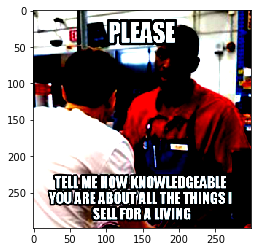

pleas tell knowledg thing sell live
tensor(1)
tensor(2)
tensor(1)


In [0]:
img,text,y1,y2,y3 = next(iter(dataloader["val"]))
imshow(img[0])
print(text[0])
print(y1[0])
print(y2[0])
print(y3[0])

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
class MemeModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super().__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.fc = nn.Linear(embed_dim, num_class)
    self.init_weights()
  
  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)


In [0]:
num_classes = 2
model_ft = models.inception_v3(pretrained=True)
set_parameter_requires_grad(model_ft, True)
# Handle the auxilary net

num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.cuda()
# model_ft

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:01<00:00, 101MB/s]  


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.01)
steps = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

In [0]:
def train_model(model, dataloaders, criterion, optimizer , num_epochs=25, is_inception=True):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for imgs, texts, c1, c2, c3 in dataloaders[phase]:
                imgs = imgs.cuda()
                # texts = texts.cuda()
                c1 = c1.cuda()
                c2 = c2.cuda()
                c3 = c3.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(imgs)
                        # print(outputs)
                        # print(c1)
                        loss1 = criterion(outputs, c1)
                        loss2 = criterion(aux_outputs, c1)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(imgs)
                        loss = criterion(outputs, c1)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()
                        # print(scheduler.get_lr())

                # statistics
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == c1.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        # print('Reset scheduler')
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
model, val_acc_history = train_model(model_ft,dataloaders=dataloader,criterion=criterion,optimizer=optimizer,num_epochs=10)

Epoch 0/9
----------


In [0]:
imgs,text,c1,c2,c3 = next(iter(dataloader["val"]))
model_ft.eval()
out = model_ft(imgs.cuda())
_, preds = torch.max(out, 1)
preds = np.array(preds.detach().cpu())
c1 = np.array(c1.detach().cpu())
acc = sum(preds == c1) 
print(acc/len(imgs))
print(out)
print(preds)
print(c1)

1.0
tensor([[ 1.5124, -1.3927],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 1.5124, -1.3927],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 2.0694, -1.9274],
        [ 1.5124, -1.3927],
        [ 2.0694, -1.9274]], device='cuda:0', grad_fn=<AddmmBackward>)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# Keras

In [0]:
num_words =10000
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(df['new_text'].values)
X_text = tokenizer.texts_to_sequences(df['new_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

max_length_of_text = 200
X_text = pad_sequences(X_text, maxlen=max_length_of_text)

print(X_text[0])
print(len(word_index))

Found 11673 unique tokens.
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   18

In [0]:
with open("tokenizer_new.pickle","wb") as handle:
  pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
!cp /content/tokenizer_new.pickle /content/drive/My\ Drive/

In [0]:
print(len(X_img))
print(len(X_text))
# y1 = df_temp.taskA
print(len(y1))
print(len(y2))
print(len(y3))

6595
6595
6595
6595
6595


In [0]:
!wget https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz

--2019-11-27 12:01:38--  https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/master/glove.6B.50d.txt.gz [following]
--2019-11-27 12:01:38--  https://raw.githubusercontent.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/master/glove.6B.50d.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69182520 (66M) [application/octet-stream]
Saving to: ‘glove.6B.50d.txt.gz’

glove.6B.50d.txt.gz 100%[===================>]  65.98M   171MB/s    in 0.4s    

201

In [0]:
! gunzip glove.6B.50d.txt.gz

In [0]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in pretrained word vector model.' % len(embeddings_index))
print('Dimensions of the vector space : ', len(embeddings_index['the']))

Found 400000 word vectors in pretrained word vector model.
Dimensions of the vector space :  50


In [0]:
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
base_model = VGG19(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model_input = Input(shape = (299,299,3))
x = base_model(model_input)
x = GlobalAveragePooling2D()(x)

length_of_text = 200
text_input = Input((length_of_text, ))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length_of_text,
                            trainable=True)
y = embedding_layer(text_input)
# y = LSTM(10,dropout=0.5,recurrent_dropout = 0.5)(y)
y = Flatten()(y)
# y = Dense(32,kernel_initializer="random_uniform")(y)
# y = LeakyReLU(alpha=0.1)(y)
# y = Dropout(rate=0.5)(y)
# y = Dense(32,kernel_initializer="random_uniform")(y)
# y = LeakyReLU(alpha=0.2)(y)
# y = Dropout(rate=0.5)(y)


middle = concatenate([x,y])
middle = Dense(32,kernel_initializer="random_uniform")(middle)
middle = LeakyReLU(alpha=0.1)(middle)
middle = Dropout(rate=0.5)(middle)

# upper = Dense(16)(x)
# upper = LeakyReLU(alpha=0.2)(upper)
# upper = Dropout(rate=0.5)(upper)

# lower = Dense(16)(y)
# lower = LeakyReLU(alpha=0.2)(lower)
# lower = Dropout(rate=0.5)(lower)

# concat = concatenate([ middle])

# x1 = Dense(16)(middle)
# x1 = LeakyReLU(alpha=0.2)(x1)
pred1 = Dense(4,activation="softmax")(middle)

# x2 = Dense(1024, activation='relu')(concat)
# pred2 = Dense(4, activation='softmax')(x2)

# x3 = Dense(64, activation='relu')(concat)
# pred3 = Dense(5, activation='softmax')(x3)

model = Model(inputs=[model_input,text_input], outputs =[pred1])
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [0]:
X_img = np.array(X_img)
X_text = np.array(X_text)
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
# X_img = X_img.astype('float') / 255

In [0]:
label2 = []
for i in y2:
  if i == 0:
    label2.append(0.0)
  elif i == 1:
    label2.append(0.25)
  elif i == 2:
    label2.append(0.5)
  else:
    label2.append(0.75)

label2 = np.array(label2)

In [0]:
y3_new = []
for i in y3:
  if i ==0 or i == 1:
    y3_new.append(0)
  elif i == 2:
    y3_new.append(1)
  else:
    y3_new.append(2)

In [0]:
label3 = []
for i in y3:
  if i == 0:
    label3.append(0.0)
  elif i == 1:
    label3.append(0.2)
  elif i == 2:
    label3.append(0.4)
  elif i == 3:
    label3.append(0.6)
  else:
    label3.append(0.8)
label3 = np.array(label3)

In [0]:
from keras.utils import to_categorical
# y1_one_hot = to_categorical(y1)
y2_one_hot = to_categorical(y2)
y3_one_hot = to_categorical(y3)

In [0]:
X_img_train, X_img_test, X_text_train, X_text_test, y1_train, y1_test = train_test_split(X_img,X_text,y2_one_hot,test_size=0.1,random_state=121,stratify=y2) 

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
vgg19 (Model)                   multiple             20024384    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 50)      531750      input_6[0][0]                    
____________________________________________________________________________________________

In [0]:
# checkpoint = ModelCheckpoint("model2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x=[X_img,X_text],y=y2_one_hot, batch_size= 128,epochs=23,class_weight=None)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/23
6595/6595 [==============================] - 36s 5ms/step - loss: 1.6362 - acc: 0.3336
Epoch 2/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.3077 - acc: 0.3789
Epoch 3/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.2469 - acc: 0.4009
Epoch 4/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.2107 - acc: 0.4091
Epoch 5/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.1701 - acc: 0.4414
Epoch 6/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.1386 - acc: 0.4552
Epoch 7/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.1043 - acc: 0.4760
Epoch 8/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.0674 - acc: 0.4972
Epoch 9/23
6595/6595 [==============================] - 35s 5ms/step - loss: 1.0570 - acc: 0.5133
Epoch 10/23
6595/6595 [=

In [0]:
pred = model.predict(x=[X_img_test,X_text_test])
y_pred = [np.round(i) if i < 3.0 else 3.0 for i in pred]
y_pred = [i if i > 0.0 else 0.0 for i in y_pred]

In [0]:
model.save_weights("/content/model_offensive_overfit2.h5")

In [0]:
!cp model_offensive_overfit2.h5 /content/drive/My\ Drive/

In [0]:
pred = model.predict(x=[X_img_test,X_text_test])

In [0]:
print(pred[:10])
print(y1_test[:10])

In [0]:
# y_pred = np.argmax(pred,axis=1)
y_pred = []
for i in pred:
  if i < 0.2:
    y_pred.append(0)
  elif i >= 0.25 and i < 0.5:
    y_pred.append(1)
  elif i >= 0.5 and i < 0.75:
    y_pred.append(2)
  # elif i >= 0.6 and i < 0.8:
    # y_pred.append(3) 
  else:
    y_pred.append(3)

In [0]:
# y1_test1 = np.argmax(y1_test,axis=1)
y1_test1 = []
for i in y1_test:
  if i == 0:
    y1_test1.append(0)
  elif i == 0.25:
    y1_test1.append(1)
  elif i == 0.5:
    y1_test1.append(2)
  elif i == 0.75:
    y1_test1.append(3) 
  # else: 
  #   y1_test1.append(4)

In [0]:
# y_pred = []
# for i in pred:
#   if i >=0.5:
#     y_pred.append(1)
#   else:
#     y_pred.append(0)
  
y1_test1 = y1_test

In [0]:
confusion_matrix(y1_test1,y_pred,labels=[0,1,2,3])

array([[ 59, 196,   3,   0],
       [ 32, 197,  14,   0],
       [  3, 111,  24,   0],
       [  0,  11,   9,   1]])

In [0]:
print("F1.........: %f" %(f1_score(y1_test1, y_pred, average="macro")))
print("Precision..: %f" %(precision_score(y1_test1, y_pred, average="macro")))
print("Recall.....: %f" %(recall_score(y1_test1, y_pred, average="macro")))
print("Accuracy...: %f" %(accuracy_score(y1_test1, y_pred)))

F1.........: 0.300311
Precision..: 0.622546
Recall.....: 0.315228
Accuracy...: 0.425758


KeyError: ignored

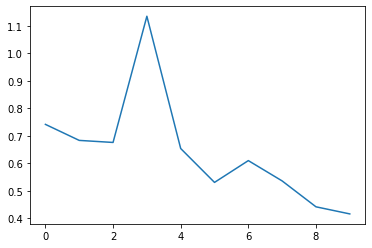

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error is : ",mean_absolute_error(y1_test1,y_pred))

Mean Absolute Error is :  0.5969696969696969


In [0]:
p = []
y2_old = []
for i in pred:
  if i<0.25:
    p.append(0)
    y2_old.append(0)
  elif i>=0.25 and i<0.50:
    p.append(1)
    y2_old.append(1)
  elif i>=0.5 and i<0.75:
    p.append(2)
    y2_old.append(2)
  else:
    p.append(3)
    y2_old.append(3)

In [0]:
print(pred)
print(y2[:10])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0.   0.   0.   0.5  0.5  0.25 0.   0.   0.25 0.25]


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_text,y2,test_size=0.2 ,random_state=121)

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC(gamma='auto')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
score_train = clf.score(X_train,y_train)

In [0]:
score_test = clf.score(X_test, y_test)

In [0]:
print(score_train)
print(score_test)

0.9850265352539803
0.3949962092494314


In [0]:
model.save_weights('model3.h5')

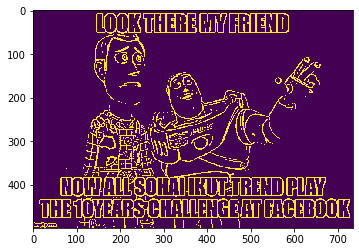

In [0]:
img = cv2.imread("/content/drive/My Drive/data_7000/"+df.imgname[0],cv2.IMREAD_GRAYSCALE)
bilFilter = cv2.bilateralFilter(img,9,75,75)
gaus = cv2.GaussianBlur(img,(3, 3), 0)
thres = cv2.adaptiveThreshold(gaus,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,5,4)
plt.imshow(thres) 

# New Section 

In [0]:
import re
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix

from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding
from keras.layers import LSTM, CuDNNLSTM, Flatten
from keras.layers import GRU, Activation, Input, concatenate
from keras.layers import Conv2D, MaxPool2D, Reshape
from keras.optimizers import Adam, SGD, RMSprop
from keras import optimizers
from keras import regularizers

from xgboost import XGBClassifier

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
trial_data = pd.read_csv("/content/drive/My Drive/data1.csv", sep=',')
train_data = pd.read_csv("/content/drive/My Drive/data_7000_new.csv", sep=',', names=['image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text', 'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment', 'Basis_of_classification'])

In [0]:
train_data.Overall_Sentiment.value_counts()

positive                                                          2912
neutral                                                           2073
very_positive                                                      958
negative                                                           439
very_negative                                                      138
positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg       1
Name: Overall_Sentiment, dtype: int64

In [0]:
# train_data = train_data[train_data.Overall_Sentiment != 'neutral']
train_data = train_data[train_data.Overall_Sentiment != 'positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg']
train_data = train_data[~train_data.Overall_Sentiment.isnull()] 
# trial_data = trial_data[trial_data.Overall_Sentiment != 'neutral']
trial_data = trial_data[~trial_data.Overall_Sentiment.isnull()]

In [0]:
train_data.Overall_Sentiment.value_counts()

positive         2912
neutral          2073
very_positive     958
negative          439
very_negative     138
Name: Overall_Sentiment, dtype: int64

In [0]:
print(train_data.shape)
print(trial_data.shape)

(6520, 10)
(914, 10)


In [0]:
def clean_tweets(tweet):
    tweet = re.sub('@(\\w{1,15})\b', '', str(tweet))
    tweet = tweet.replace("via ", "")
    tweet = tweet.replace("RT ", "")
    tweet = tweet.lower()
    return tweet
    
def clean_url(tweet):
    tweet = re.sub('http\\S+', '', tweet, flags=re.MULTILINE)   
    return tweet
    
def remove_stop_words(tweet):
    stops = set(stopwords.words("english"))
    stops.update(['.',',','"',"'",'?',':',';','(',')','[',']','{','}'])
    toks = [tok for tok in tweet if not tok in stops and len(tok) >= 3]
    return toks
    
def stemming_tweets(tweet):
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in tweet]
    return stemmed_words

def remove_number(tweet):
    newTweet = re.sub('\\d+', '', tweet)
    return newTweet

def remove_hashtags(tweet):
    result = ''

    for word in tweet.split():
        if word.startswith('#') or word.startswith('@'):
            result += word[1:]
            result += ' '
        else:
            result += word
            result += ' '

    return result

def preprocessing(tweet, swords = True, url = True, stemming = True, ctweets = True, number = True, hashtag = True):

    if ctweets:
        tweet = clean_tweets(tweet)

    if url:
        tweet = clean_url(tweet)

    if hashtag:
        tweet = remove_hashtags(tweet)
    
    twtk = TweetTokenizer(strip_handles=True, reduce_len=True)

    if number:
        tweet = remove_number(tweet)
    
    tokens = [w.lower() for w in twtk.tokenize(tweet) if w != "" and w is not None]

    if swords:
        tokens = remove_stop_words(tokens)

    if stemming:
        tokens = stemming_tweets(tokens)

    text = " ".join(tokens)

    return text

In [0]:
train_text  = train_data['corrected_text'].map(lambda x: preprocessing(x, swords = True, url = True, stemming = True, ctweets = True, number = True, hashtag = True))
s_train     = train_data['Overall_Sentiment']

trial_text  = trial_data['corrected_text'].map(lambda x: preprocessing(x, swords = True, url = True, stemming = True, ctweets = True, number = True, hashtag = True))
s_trial     = trial_data['Overall_Sentiment']

In [0]:
print(len(train_text), len(s_train))
print(len(trial_text), len(s_trial))

4448 4448
637 637


In [0]:
def bag_of_words(train, test):
    vec = CountVectorizer()
    train = vec.fit_transform(train).toarray()
    test = vec.transform(test).toarray()
    print(vec.vocabulary_)
    return train, test

In [0]:
x_train, x_test = bag_of_words(train_text, trial_text)

{'look': 4918, 'friend': 3086, 'lightyear': 4825, 'sohalikut': 7698, 'trend': 8578, 'play': 6347, 'year': 9394, 'challeng': 1350, 'facebook': 2743, 'imgflip': 4044, 'com': 1613, 'best': 809, 'yearchalleng': 9395, 'complet': 1653, 'less': 4775, 'kudus': 4621, 'narendramodi': 5639, 'jan': 4343, 'mumbai': 5574, 'india': 4106, 'sam': 7178, 'thorn': 8403, 'strippin': 7996, 'follow': 2982, 'saw': 7231, 'everyon': 2666, 'post': 6437, 'pic': 6293, 'here': 3708, 'mine': 5390, 'retweet': 6958, 'like': 4829, 'sweet': 8129, 'dee': 2053, 'edit': 2479, 'filter': 2896, 'hilari': 3747, 'meme': 5228, 'get': 3284, 'car': 1247, 'stranger': 7978, 'meet': 5204, 'peopl': 6220, 'internet': 4211, 'alon': 230, 'memecenter': 5239, 'uber': 8707, 'order': 5994, 'lit': 4859, 'erg': 2612, 'wow': 9328, 'transform': 8555, 'emot': 2548, 'boredpanda': 980, 'fornit': 3018, 'die': 2189, 'month': 5489, 'minecraft': 5391, 'never': 5714, 'proud': 6588, 'communiti': 1645, 'ploy': 6364, 'simpl': 7533, 'exo': 2699, 'minh': 539

(4448, 7590)
(4448,)


In [0]:
xgb = XGBClassifier()

In [0]:
xgb.fit(x_train,s_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
xgb.score(x_train,s_train)

0.4656441717791411

In [0]:
y_pred = xgb.predict(x_test)

In [0]:
print("F1.........: %f" %(f1_score(s_trial, y_pred, average="macro")))
print("Precision..: %f" %(precision_score(s_trial, y_pred, average="macro")))
print("Recall.....: %f" %(recall_score(s_trial, y_pred, average="macro")))
print("Accuracy...: %f" %(accuracy_score(s_trial, y_pred)))

F1.........: 0.081793
Precision..: 0.160196
Recall.....: 0.127256
Accuracy...: 0.450766


In [0]:
confusion_matrix(s_trial, y_pred, labels=["positive", "very_positive", "neutral", "negative", "very_negative"])

array([[407,   0,   0,   0,   0],
       [148,   0,   1,   0,   0],
       [272,   0,   5,   0,   0],
       [ 50,   0,   0,   0,   0],
       [ 20,   0,   0,   0,   0]])

In [0]:
print(y_pred)

['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'posit

# XLNet

In [0]:
sentences = df.new_text.values

In [0]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.taskA.values

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 798011/798011 [00:00<00:00, 11638405.68B/s]


Tokenize the first sentence:
['▁spend', '▁', 's', 'atur', 'day', '▁detention', '▁everyone', '▁else', '▁ends', '▁couples', '▁still', '▁alone', '▁picked', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [0]:
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

100%|██████████| 467042463/467042463 [00:07<00:00, 58544684.17B/s]


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6601764056631314


Epoch:  25%|██▌       | 1/4 [01:50<05:32, 110.95s/it]

Validation Accuracy: 0.6392857142857143
Train loss: 0.65673081849211


Epoch:  50%|█████     | 2/4 [03:41<03:41, 110.85s/it]

Validation Accuracy: 0.6392857142857143
Train loss: 0.6544092050803605


Epoch:  75%|███████▌  | 3/4 [05:32<01:50, 110.78s/it]

Validation Accuracy: 0.6392857142857143
Train loss: 0.6552379366851622


Epoch: 100%|██████████| 4/4 [07:22<00:00, 110.74s/it]

Validation Accuracy: 0.6392857142857143


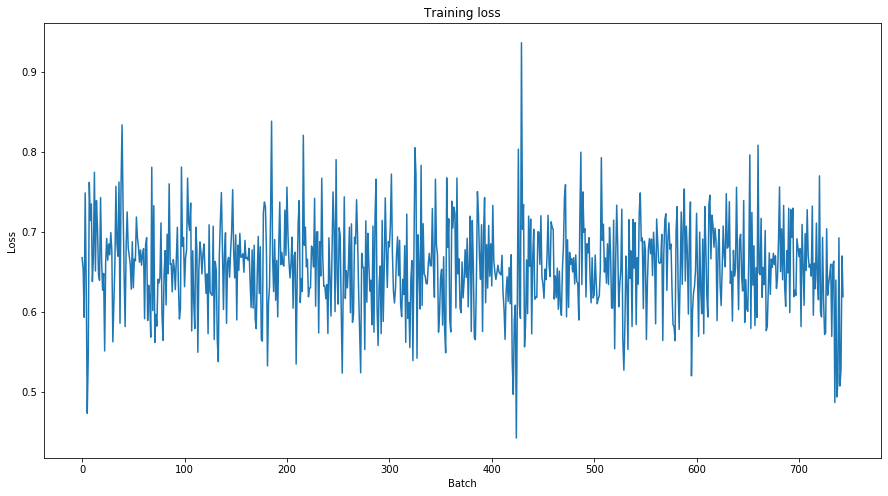

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()